# Getting used to VTK

date = 30 September, 2020 <br>

history <br>
2020-30-09 Basic VTK Pipeline <br>
2020-30-09 Read dicoms and visualize in 3D and 2D - with ImageViewer2, ImageActor, other Actors<br>
2020-30-09 Read pns and visualize in 2D - with ImageViewer2, ImageActor, Actor<br>

In [1]:
import vtk
from vtk.util import numpy_support
import os
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.path.abspath('../../'))

### Basic VTK Pipeline
render sphere to see basic VTK pipeline

In [3]:
# Create source
source = vtk.vtkSphereSource()
source.SetCenter(0, 0, 0)
source.SetRadius(5.0)

# Create a mapper
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(source.GetOutputPort())

# Create an actor
actor = vtk.vtkActor()
actor.SetMapper(mapper)

# Create renderer
renderer = vtk.vtkRenderer()
renderer.SetBackground(1.0, 1.0, 1.0)
renderer.AddActor(actor)

# Create window
window = vtk.vtkRenderWindow()
# Sets the pixel width, length of the window.
window.SetSize(500, 500)
window.AddRenderer(renderer)

# Create interactor
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(window)

### Read Dicoms and visualize 3D data
render dicom images in 3D scene

In [4]:
folder = "../../Data/1/CT"

In [5]:
# Read all the DICOM files in the specified directory.
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(folder)
reader.Update()
imageData = reader.GetOutput()

# Create a mapper
volumeMapper = vtk.vtkSmartVolumeMapper()
volumeMapper.SetInputData(imageData)

# Create volume property
# - opacity
# - color transfer function
volumeProperty = vtk.vtkVolumeProperty()
volumeProperty.ShadeOff()
volumeProperty.SetInterpolationType(vtk.VTK_LINEAR_INTERPOLATION)

compositeOpacity = vtk.vtkPiecewiseFunction()
compositeOpacity.AddPoint(0.0,0.0)
compositeOpacity.AddPoint(80.0,1.0)
compositeOpacity.AddPoint(80.1,0.0)
compositeOpacity.AddPoint(255.0,0.0)
volumeProperty.SetScalarOpacity(compositeOpacity)

color = vtk.vtkColorTransferFunction()
color.AddRGBPoint(0.0  ,0.0,0.0,1.0)
color.AddRGBPoint(100.0  ,0.0,1.0,0.0)
color.AddRGBPoint(255.0,1.0,1.0,1.0)
volumeProperty.SetColor(color)

# Create volume
volume = vtk.vtkVolume()
volume.SetMapper(volumeMapper)
volume.SetProperty(volumeProperty)

# Create renderer
renderer = vtk.vtkRenderer();
renderer.SetBackground(0, 0, 0);
renderer.AddViewProp(volume)
renderer.ResetCamera()

# Create renderwindow
window = vtk.vtkRenderWindow();
window.AddRenderer(renderer);
window.SetSize(600,600);

# Create interactor
interactor = vtk.vtkRenderWindowInteractor();
interactor.SetRenderWindow(window);

### Read Dicoms and visualize 2D data
render dicom images in 2D planes with slicing through volume

In [6]:
folder = "../../Data/1/T1 +C 3-15-16"

In [7]:
# Read all the DICOM files in the specified directory.
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(folder)
reader.Update()

# Calculate the center of the volume
xMin, xMax, yMin, yMax, zMin, zMax = reader.GetDataExtent()
xSpacing, ySpacing, zSpacing = reader.GetOutput().GetSpacing()
x0, y0, z0 = reader.GetOutput().GetOrigin()
center = [x0 + xSpacing * 0.5 * (xMin + xMax),
          y0 + ySpacing * 0.5 * (yMin + yMax),
          z0 + zSpacing * 0.5 * (zMin + zMax)]
    
# Matrices for axial, coronal, sagittal, oblique view orientations
axial = vtk.vtkMatrix4x4()
axial.DeepCopy((1, 0, 0, center[0],
                0, 1, 0, center[1],
                0, 0, 1, center[2],
                0, 0, 0, 1))

# Extract a slice in the desired orientation
reslice = vtk.vtkImageReslice()
reslice.SetInputConnection(reader.GetOutputPort())
reslice.SetOutputDimensionality(2)
reslice.SetResliceAxes(axial)
reslice.SetInterpolationModeToCubic()

# Create a greyscale lookup table
table = vtk.vtkLookupTable()
table.SetRange(0, 2000) # image intensity range
table.SetValueRange(0.0, 1.0) # from black to white
table.SetSaturationRange(0.0, 0.0) # no color saturation
table.SetRampToLinear()
table.Build()

# Map the image through the lookup table
color = vtk.vtkImageMapToColors()
color.SetLookupTable(table)
color.SetInputConnection(reslice.GetOutputPort())

# Display the image
actor = vtk.vtkImageActor()
actor.GetMapper().SetInputConnection(color.GetOutputPort())

# Create renderer
renderer = vtk.vtkRenderer();
renderer.SetBackground(0, 0, 0);
renderer.AddActor(actor)
renderer.ResetCamera()

# Create renderwindow
window = vtk.vtkRenderWindow();
window.AddRenderer(renderer);
window.SetSize(400,400);
window.SetWindowName("Test")

# Create interactor
interactor = vtk.vtkRenderWindowInteractor();
interactor.SetRenderWindow(window);

In [8]:
def ButtonCallback(obj, event):
    if event == "LeftButtonPressEvent":
        actions["Slicing"] = 1
    else:
        actions["Slicing"] = 0

def MouseMoveCallback(obj, event):
    (lastX, lastY) = interactor.GetLastEventPosition()
    (mouseX, mouseY) = interactor.GetEventPosition()
    if actions["Slicing"] == 1:
        deltaY = mouseY - lastY
        reslice.Update()
        sliceSpacing = reslice.GetOutput().GetSpacing()[2]
        matrix = reslice.GetResliceAxes()
        # move the center point that we are slicing through
        center = matrix.MultiplyPoint((0, 0, sliceSpacing*deltaY, 1))
        matrix.SetElement(0, 3, center[0])
        matrix.SetElement(1, 3, center[1])
        matrix.SetElement(2, 3, center[2])
        window.Render()
    else:
        interactorStyle.OnMouseMove()

In [9]:
# Create interactor style
interactorStyle = vtk.vtkInteractorStyleImage()
interactor.SetInteractorStyle(interactorStyle)
window.SetInteractor(interactor)

# Create callbacks for slicing the image
actions = {}
actions["Slicing"] = 0
 
interactorStyle.AddObserver("MouseMoveEvent", MouseMoveCallback)
interactorStyle.AddObserver("LeftButtonPressEvent", ButtonCallback)
interactorStyle.AddObserver("LeftButtonReleaseEvent", ButtonCallback)

6

### ImageViewer with Dicom reader
only first slide shown 

### Read png image
not showing anything

In [10]:
path_data = "../../Data/1/Segmentation/png/"

../../Data/1/Segmentation/png/1_slice107.png


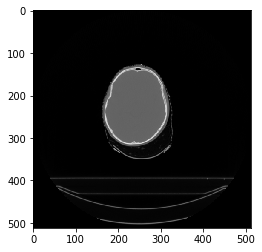

In [11]:
# List of png files - choose one
pngfiles = [os.path.join(path_data,x) for x in os.listdir(path_data)]
png_path = pngfiles[10]
print(png_path)
plt.imshow(cv2.imread(png_path))

In [12]:
# Read png
png_reader = vtk.vtkPNGReader()
png_reader.SetFileName(png_path)
png_reader.Update()
png_data = png_reader.GetOutputPort()

# Create a mapper
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(png_data)

# Create an actor
actor = vtk.vtkActor()
actor.SetMapper(mapper)

# Create renderer
renderer = vtk.vtkRenderer()
renderer.SetBackground(1.0, 1.0, 1.0)
renderer.AddActor(actor)

# Create window
window = vtk.vtkRenderWindow()
# Sets the pixel width, length of the window.
window.SetSize(500, 500)
window.AddRenderer(renderer)

# Create interactor
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(window)

### Read png image with ImageSliceMapper
showing one slice

In [13]:
# Read png
png_reader = vtk.vtkPNGReader()
png_reader.SetFileName(png_path)
png_reader.Update()
png_data = png_reader.GetOutputPort()

# Create a image slice mapper
mapper = vtk.vtkImageSliceMapper()
mapper.SetInputConnection(png_data)

# Create an image slice
imgslice = vtk.vtkImageSlice()
imgslice.SetMapper(mapper)

# Create renderer
renderer = vtk.vtkRenderer()
renderer.SetBackground(1.0, 1.0, 1.0)
renderer.AddViewProp(imgslice)

# Create window
window = vtk.vtkRenderWindow()
# Sets the pixel width, length of the window.
window.SetSize(500, 500)
window.AddRenderer(renderer)

# Create interactor
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(window)

### Read png with ImageActor
showing one slide

In [14]:
path_data = "../../Data/1/Segmentation/png/"
# List of png files - choose one
pngfiles = [os.path.join(path_data,x) for x in os.listdir(path_data)]
png_path = pngfiles[10]

In [15]:
filePath = vtk.vtkStringArray()
filePath.SetNumberOfValues(len(pngfiles))
for i in range(0,len(pngfiles),1):
    filePath.SetValue(i,pngfiles[i])
filePath

(vtkCommonCorePython.vtkStringArray)00000030E8F1C288

In [16]:
# Read png
png_reader = vtk.vtkPNGReader()
#png_reader.SetFileName(pngfile)
png_reader.SetFileNames(filePath)
png_reader.Update()
png_data = png_reader.GetOutput()

# Create an image actor
actor = vtk.vtkImageActor()
actor.SetInputData(png_data)

# Create renderer
renderer = vtk.vtkRenderer()
renderer.SetBackground(1.0, 1.0, 1.0)
renderer.AddViewProp(actor)

# Create interactor
interactorStyle = vtk.vtkInteractorStyleImage()
interactorStyle.SetInteractionModeToImageSlicing()
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetInteractorStyle(interactorStyle)

# Create window
window = vtk.vtkRenderWindow()
# Sets the pixel width, length of the window.
window.SetSize(500, 500)
window.AddRenderer(renderer)
window.SetInteractor(interactor)

### Read png series with numpy converting
showing one slice

In [17]:
# List of png files
pngfiles = [os.path.join(path_data,x) for x in os.listdir(path_data)]

# Get dimensions of pngs
png_reader = vtk.vtkPNGReader()
png_reader.SetFileName(pngfiles[0])
png_reader.Update()
x,y,z = png_reader.GetOutput().GetDimensions()
print('size', x, y, z)

# Read png files and store as numpy array
png_reader = vtk.vtkPNGReader()
data_3Dnp = []
for i,p in enumerate(pngfiles):
    png_reader.SetFileName(p)
    png_reader.Update()
    img_data = png_reader.GetOutput()
    vtk_data = img_data.GetPointData().GetScalars()
    numpy_data = np.flip(numpy_support.vtk_to_numpy(vtk_data).reshape(x,y))
    data_3Dnp.append(numpy_data)
    
# Convert numpy array to vtk data
data_3D = np.stack(data_3Dnp, axis=0)
data_3Dvtk = numpy_support.numpy_to_vtk(data_3D.ravel())

size 512 512 1


In [18]:
# Create image data
imageData = vtk.vtkImageData()
imageData.GetPointData().SetScalars(data_3Dvtk)
imageData.SetDimensions(x,y,len(pngfiles))
imageData.SetSpacing(1.0, 1.0, 1.0 )
imageData.SetOrigin(0.0, 0.0, 0.0 )

# Create an image actor
actor = vtk.vtkImageActor()
actor.SetInputData(imageData)

# Create renderer
renderer = vtk.vtkRenderer()
renderer.SetBackground(1.0, 1.0, 1.0)
renderer.AddViewProp(actor)

# Create window
window = vtk.vtkRenderWindow()
# Sets the pixel width, length of the window.
window.SetSize(500, 500)
window.AddRenderer(renderer)

# Create interactor
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(window)

### Read png series via png reader and imageviewer2

In [19]:
path_data = "../../Data/1/Segmentation/t0/Brain"
pngfiles = [os.path.join(path_data,x) for x in os.listdir(path_data)][:11]
len(pngfiles)

11

In [20]:
pngfiles

['../../Data/1/Segmentation/t0/Brain\\1_t0_Brain_slice100.png',
 '../../Data/1/Segmentation/t0/Brain\\1_t0_Brain_slice101.png',
 '../../Data/1/Segmentation/t0/Brain\\1_t0_Brain_slice102.png',
 '../../Data/1/Segmentation/t0/Brain\\1_t0_Brain_slice103.png',
 '../../Data/1/Segmentation/t0/Brain\\1_t0_Brain_slice104.png',
 '../../Data/1/Segmentation/t0/Brain\\1_t0_Brain_slice105.png',
 '../../Data/1/Segmentation/t0/Brain\\1_t0_Brain_slice106.png',
 '../../Data/1/Segmentation/t0/Brain\\1_t0_Brain_slice107.png',
 '../../Data/1/Segmentation/t0/Brain\\1_t0_Brain_slice108.png',
 '../../Data/1/Segmentation/t0/Brain\\1_t0_Brain_slice109.png',
 '../../Data/1/Segmentation/t0/Brain\\1_t0_Brain_slice110.png']

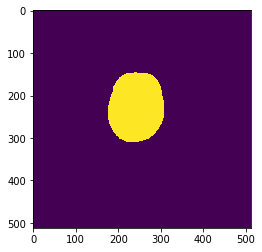

In [21]:
plt.imshow(cv2.imread(pngfiles[10], cv2.IMREAD_GRAYSCALE))

## Plot contour of mask

In [22]:
import math

In [23]:
def stencilData(pd, inval):
    
    bounds = pd.GetBounds()
    print(bounds)
    
    whiteImage = vtk.vtkImageData()
    spacing = [0]*3
    # 0.25 by rr, 0.7->16, 1.5->8,
    spacing[0] = 0.5
    spacing[1] = 0.5
    spacing[2] = 0.5
    whiteImage.SetSpacing(spacing)

    dim = [0]*3
    for i in range(3):
        dim[i] = int(math.ceil((bounds[i * 2 + 1] - bounds[i * 2]) / spacing[i])) + 1
        if (dim[i] < 1):
            dim[i] = 1
    whiteImage.SetDimensions(dim)
    whiteImage.SetExtent(0, dim[0] - 1, 0, dim[1] - 1, 0, dim[2] - 1)
    print("dims", dim)

    origin = [0]*3
    origin[0] = bounds[0]
    origin[1] = bounds[2]
    origin[2] = bounds[4]
    whiteImage.SetOrigin(origin)
    whiteImage.AllocateScalars(vtk.VTK_UNSIGNED_CHAR, 1)
    print("origin", origin)

    outval = 0
    count = whiteImage.GetNumberOfPoints()
    for i in range(count):
        whiteImage.GetPointData().GetScalars().SetTuple1(i, inval)

    pol2stenc = vtk.vtkPolyDataToImageStencil()
    pol2stenc.SetTolerance(0)
    pol2stenc.SetInputData(pd)
    pol2stenc.SetOutputOrigin(origin)
    pol2stenc.SetOutputSpacing(spacing)
    pol2stenc.SetOutputWholeExtent(whiteImage.GetExtent())
    pol2stenc.Update()

    imgstenc = vtk.vtkImageStencil()
    imgstenc.SetInputData(whiteImage)
    imgstenc.SetStencilConnection(pol2stenc.GetOutputPort())
    imgstenc.ReverseStencilOff()
    imgstenc.SetBackgroundValue(outval)
    imgstenc.Update()

    # print("stencil: ", imgstenc.GetOutput())

    changeInformation = vtk.vtkImageChangeInformation()
    changeInformation.SetInputData(imgstenc.GetOutput())
    changeInformation.CenterImageOn()
    changeInformation.Update()

    # print("stencil centered: ", changeInformation.GetOutput())
    return changeInformation

In [24]:
filePath = vtk.vtkStringArray()
len(pngfiles)
filePath.SetNumberOfValues(len(pngfiles))
for i in range(0,len(pngfiles),1):
    filePath.SetValue(i,pngfiles[i])
filePath

png_reader = vtk.vtkPNGReader()
png_reader.SetFileNames(filePath)
png_reader.Update()
print("dim png", png_reader.GetOutput().GetExtent())

# Contour
iso = vtk.vtkContourFilter()
iso.SetInputData(png_reader.GetOutput())
iso.GenerateValues(1, 1, 255)

pd = iso.GetOutput()
print("pd bounds", pd.GetBounds())

dim png (0, 511, 0, 511, 0, 10)
pd bounds (1.0, -1.0, 1.0, -1.0, 1.0, -1.0)


In [25]:
png_reader.GetOutput(), iso.GetOutput()

((vtkCommonDataModelPython.vtkImageData)00000030E8F74528,
 (vtkCommonDataModelPython.vtkPolyData)00000030E8F742E8)

In [26]:
imageContour = stencilData(iso.GetOutput(), 125)
imageContour.GetOutputPort()

(1.0, -1.0, 1.0, -1.0, 1.0, -1.0)
dims [1, 1, 1]
origin [1.0, 1.0, 1.0]


(vtkCommonExecutionModelPython.vtkAlgorithmOutput)00000030E8F74828

In [27]:
imageContour.GetOutput().GetDimensions()

(1, 1, 1)

In [28]:
# Create an image actor
actor = vtk.vtkImageSlice()
actor.SetMapper(vtk.vtkImageSliceMapper())
actor.GetMapper().SetInputConnection(imageContour.GetOutputPort())
#actor.GetMapper().SetSliceNumber(0)

In [29]:
# Create renderer
renderer = vtk.vtkRenderer()
renderer.SetBackground(1.0, 1.0, 1.0)
renderer.AddActor(actor)

# Create window
window = vtk.vtkRenderWindow()
# Sets the pixel width, length of the window.
window.SetSize(500, 500)
window.AddRenderer(renderer)

# Create interactor
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(window)

In [30]:
window.Render()
interactor.Start()

In [38]:
normals = vtk.vtkPolyDataNormals()
normals.SetInputConnection(iso.GetOutputPort())
normals.SetFeatureAngle(45)

isoMapper = vtk.vtkPolyDataMapper()
isoMapper.SetInputConnection(normals.GetOutputPort())
isoMapper.ScalarVisibilityOn()
isoMapper.SetScalarRange(0, 255)
#isoMapper.SetScalarModeToUsePointFieldData()
#isoMapper.ColorByArrayComponent("VelocityMagnitude", 0)

# Create an actor
isoActor = vtk.vtkActor()
isoActor.SetMapper(isoMapper)
isoActor.GetProperty().SetColor(0,255,0)
isoActor.GetProperty().SetLineWidth(25)

# Create renderer
renderer = vtk.vtkRenderer()
renderer.SetBackground(1.0, 1.0, 1.0)
renderer.AddActor(isoActor)

# Create window
window = vtk.vtkRenderWindow()
# Sets the pixel width, length of the window.
window.SetSize(500, 500)
window.AddRenderer(renderer)

# Create interactor
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(window)